In [23]:
%matplotlib inline

# Calculate street features, save them to MongoDB 🚗 🚗 🚗

This notebook calculates street features (sinuosity), and saves them to MongoDB.  

Created on:  2016-12-14  
Last update: 2016-12-14  
Contact: michael.szell@moovel.com, michael.szell@gmail.com (Michael Szell)

## Preliminaries

### Parameters

In [24]:
cityname = "berlin"

### Imports

In [25]:
from __future__ import unicode_literals
import sys
import csv
import os
import math
import pprint
pp = pprint.PrettyPrinter(indent=4)
import requests
import gzip
from collections import defaultdict
import time
import datetime
import numpy as np
from scipy import stats
import pyprind
import itertools
import logging
from ast import literal_eval as make_tuple
from collections import OrderedDict
from retrying import retry

import osmnx as ox
import networkx as nx
import json
from shapely.geometry import mapping, shape, LineString, LinearRing, Polygon, MultiPolygon
import shapely
import shapely.ops as ops
from functools import partial
import pyproj
from scipy import spatial
from haversine import haversine

import pymongo
from pymongo import MongoClient

# plotting stuff
import matplotlib.pyplot as plt

with open("citydata/" + cityname +"_streetnames.txt", "r") as ins:
    streetnames = []
    for line in ins:
        streetnames.append(line.rstrip('\n'))

### DB Connection

In [26]:
client = MongoClient()
db_raw = client[cityname+'_raw']
ways_raw = db_raw['ways']
nodes_raw = db_raw['nodes']
db_derived = client[cityname+'_derived']
streets = db_derived['streets']
ways_derived = db_derived['ways']

### Functions

In [27]:
def file_len(fname): # http://stackoverflow.com/questions/845058/how-to-get-line-count-cheaply-in-python
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def get_sinuosity(street):
    endpointslength = 0
    for component in street["components"]:
        for path in component:
            pt1 = street["nodes"][path[0]]
            pt2 = street["nodes"][path[-1]]
            endpointslength += 1000*haversine((pt1["lat"],pt1["lon"]), (pt2["lat"],pt2["lon"]))
    sinuosity = street["tags"]["length"] / endpointslength
    return sinuosity

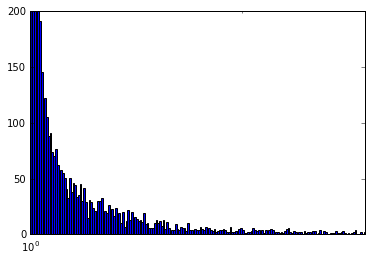

In [42]:
cursor = streets.find()
sinuosities = []
for s in cursor:
    sinuosities.append(get_sinuosity(s))
#     print(s["tags"]["name"] + " has sinuosity " + str(get_sinuosity(s)))

plt.hist(sinuosities,  bins=np.logspace(0, 0.5, 200))
plt.gca().set_xscale("log")
plt.axis([1,3,0,200])
plt.show()